## Fourier tests

This time with Wiener / other transforms!

#### Imports

In [1]:
%reload_ext autoreload
%autoreload 2

from math import ceil
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import fft 
from scipy.optimize import curve_fit

from tqdm import tqdm

from astropy import units as u
from astropy.io import fits
from astropy.visualization import simple_norm
import photutils as phot
from photutils.aperture import EllipticalAperture, CircularAnnulus, CircularAperture
from astropy.convolution import Gaussian2DKernel, convolve, Moffat2DKernel, Box2DKernel, convolve_fft
from astropy.stats import gaussian_fwhm_to_sigma, sigma_clipped_stats, sigma_clip
from skimage import transform as T
from scipy.interpolate import griddata

import galsim

# from asymmetry import get_asymmetry
from galaxy_generator import gen_image, gen_galaxy, petrosian_sersic, create_clumps, add_source_to_image, sky_noise, petrosian_sersic
# from asymmetry import get_asymmetry, get_residual

In [2]:
plt.rcParams['font.size']=10

## Generating a galaxy

Again, we write a code to generate a galaxy... the order is:

1. Generate a Sersic galaxy image
2. Generate some "clumps" (point sources with variable size)
3. Add everything onto the image & convolve with the PSF
4. Add noise

We want to look at both the 'pristine' (noiseless, PSF-free) and a 'real' galaxy

In [5]:
def make_perfect_galaxy(
    mag, r_eff, fov_reff=10, pxscale=0.396, sersic_n=1, q=1, beta=0, 
    sky_mag=23.7,  psf_fwhm=1.32, rms_noise=True,
    n_clumps=10, clump_properties=None, random_clump_properties=None, use_moffat=False
):
    
    #################### SDSS set-up ###########################
    sdss_ra = 150
    sdss_dec = 2.3
    # filt = 'r'
    # bandpass_file = "templates/passband_sdss_" + filt
    # bandpass = galsim.Bandpass(bandpass_file, wave_type = u.angstrom)
    # ## gain, exptime and diameter of telescope
    # telescope_params = {'g':4.8, 't_exp':53.91, 'D':2.5}
    # ## effective wavelength and width of filter
    # transmission_params = {'eff_wav':616.5, 'del_wav':137}
    
    ############## Sersic profile only #########################
    # Calculate field of view in degrees
    fov = fov_reff * r_eff / 3600
    
    # generate blank image with fov and wcs info
    field_image, wcs = gen_image(sdss_ra, sdss_dec, pxscale, fov, fov)

    # create a galaxy with given params
    galaxy = gen_galaxy(mag=mag, re=r_eff, n=sersic_n, q=q, beta=beta)
    
    # get petrosian radius of galaxy in px
    r_pet = petrosian_sersic(fov, r_eff, 1)/pxscale
    
    ############## Asymmetry clumps ############################
     # generate all the clumps and their positions
    clumps, all_xi, all_yi = create_clumps(field_image, r_pet, n_clumps, mag, clump_properties, random_clump_properties)
    
    
    ############## Perfect image ###############################
    image_perfect = add_source_to_image(field_image, galaxy, clumps, all_xi, all_yi, 0, pxscale)

    
    ############## Convolved image #############################
    image_psf = add_source_to_image(field_image, galaxy, clumps, all_xi, all_yi, psf_fwhm, pxscale, use_moffat=use_moffat, psf_method="astropy")
    
    
    ############## Add noise ####################################
    image_noise, noise = sky_noise(image_psf, sky_mag, pxscale, rms_noise=rms_noise)
    
    return image_perfect, image_noise, noise

Set some typical properties:

In [6]:
# Asymmetry clumps
clump_properties = {
    'r' : [0.8],
    'theta' : [90],
    'flux' : [0.3],
    'sigma' : [0.8]
}

mag = 15.5
r = 5
q = 0.5
n = 4
n_clumps = 50

pxscale = 0.2
psf_fwhm = 1.5
psf_std = psf_fwhm * gaussian_fwhm_to_sigma

Generate an example galaxy:

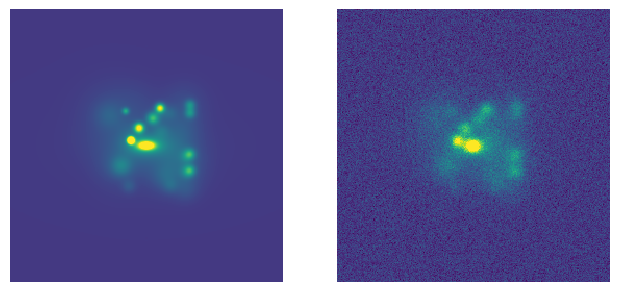

In [25]:
perfect_gal, real_gal, bg = make_perfect_galaxy(mag, r, 10.5, pxscale, n, q, n_clumps=n_clumps, 
                                                sky_mag=22.5, psf_fwhm=psf_fwhm, clump_properties=None)
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(perfect_gal, vmin=-200, vmax=1000)
axs[1].imshow(real_gal, vmin=-200, vmax=1000)
for ax in axs: ax.axis('off')

## Reconstructing the image

There are a few approaches to reconstructing the image, here we try three.

### Naive

Simply divide by the (known) PSF, but clip the PSF to some value ($10^{-2}$).

In [26]:
def recon_naive(img_fft, psf_fft, clip=1e-2):
    psf_fft_naive = psf_fft.copy()
    psf_fft_naive[np.abs(psf_fft_naive) < clip] = clip
    H = 1/psf_fft_naive
    return img_fft*H, H

### SNR estimation

For the other two approaches, we need a function that will estimate the SNR from the image, since we don't know the original SNR. 
> Also, the original image might have "too high" a SNR which doesn't account for numerical noise, so even using the known original can be bad

Here we estimate the SNR in two ways:

1. Naive: simply calculate SNR from the observed image
    * Problem: the SNR never really goes below 1, which should be the case at high frequencies
2. Fit: use high-SNR frequencies to *fit* a function for $\textrm{SNR}(\omega)$

In both cases we include an additional term of "Poisson" noise, which even in the noiseless case can help deal with numerical errors, so

$$ \textrm{SNR} = \frac{f}{\sqrt{\sigma^2 + f}} $$

#### Simple SNR

Simply calculate the observed image signal divided by the observed image noise. The noise is a combination of sky noise and Poisson noise from the observed image.

In [27]:
def get_snr_simple(img_fft, noise_fft):
    snr = np.abs(img_fft) / (noise_fft)
    return snr

#### Real SNR

Of course we can't know this in practice, but for tests we can also use "real SNR", derived from the known source image

In [28]:
def get_snr_real(real_fft, img_fft, noise_fft):
    snr = np.abs(real_fft) / (np.sqrt(noise_fft**2) )
    return snr

#### Fitted SNR

Now we use the fact that SNR varies fairly predictably in Fourier space: it is higher at low frequencies, but high-frequencies are dominated by noise (even numerical). We use the SNR we're fairly confident about to fit a function to the SNR dependence on frequency.

Just looking at it by eye, it looks like the dependence is

$ \log \textrm{SNR}(\omega) \propto \omega^2 $

So this is what we fit.

We want to fit a quadratic function in $\log \textrm{SNR}$ - $\omega$ space. We know that
* SNR minimum is at the highest frequency, i.e. exactly the center of the FFT array;
* SNR is always positive
* The SNR function is strictly increasing 
So we fit the function of the form

\begin{align}
&\log \textrm{SNR} = A (\omega_x - \omega_c)^2 (\omega_y - \omega_c)^2 + B (\omega_x - \omega_c)^2 + C (\omega_y - \omega_c) + D \\
& A, B, C \geq 0; \qquad -\infty < D < \infty
\end{align}

In [29]:
class fitQuadratic:
    # Utility class to do the fitting & pass the central frequency parameter
    def __init__(self, xc, xdata, ydata):
        self.xc = xc
        self.xdata = xdata
        self.ydata = ydata
        
    
    def quadratic(self, X, A, B, C, D):    
        # X should be 2xN array
        x, y = X
    
        # 2D quadratic function
        f = A*(x-self.xc)**2 *(y-self.xc)**2 + B*(x-self.xc)**2  + C*(y-self.xc)**2 + D
        return f
    
    def fit(self):
        self.res = curve_fit(self.quadratic, self.xdata, self.ydata, bounds=([0,0,0,-np.inf],4*[np.inf]))[0]

So the fitting function does as follows:

* Select "good SNR" regions
    * The top 1% SNR or SNR=4, whiever is greater
    
* Use those values to fit the quadratic

> <font color='red'>There are still things I don't  quite understand here: the estimated SNR does not match the "real" SNR if the noise is too low; seems like SNR is overestimated if I just use the noise + poisson</font>

In [30]:
def fit_snr(img_fft, noise_fft):
    
    # Image x, y arrays
    xc = int(img_fft.shape[0]/2)
    xs = np.arange(img_fft.shape[0])
    XS, YS = np.meshgrid(xs, xs)

    # Calculate SNR
    snr = np.sqrt(img_fft*np.conj(img_fft) / (noise_fft**2 + np.abs(img_fft)))
    snr = np.abs(snr)
    
    # Choose indices where SNR is high 
    snr_lim = np.quantile(snr, 0.98)
    snr_lim = np.max([snr_lim, 4])
    good_ids = np.nonzero(snr >snr_lim)
    good_log_snr = np.log10(snr[good_ids])
    good_xs = XS[good_ids]
    good_ys = YS[good_ids]
    
    # Use that to fit the real SNR for low-SNR regions
    fit_inst = fitQuadratic(xc=xc, xdata= np.array([good_xs, good_ys]), ydata=good_log_snr)
    fit_inst.fit()
    
    # Rewrite high-SNR regions with the real values
    fit_snr = fit_inst.quadratic(np.array([XS,YS]), *fit_inst.res)
    fit_snr = np.power(10, fit_snr)
    fit_snr[good_ids] = snr[good_ids]
    
    return fit_snr

#### Fitted SNR 2.0

An alternative approach to fitting SNR that (hopefully) should deal with both Fourier numerical noise and actual noise in the image, although doesn't that sound like wishful thinking...

* Sigma-clip the image in the Fourier space to get *just* the noise array.
    * When noise limited, this will approximate background noise
    * When numerical noise limited, this should be a pretty smooth function
    
* Estimate signal to noise in high SNR regions
* Fit SNR as a quadratic

In [31]:
def fit_snr2(img_fft, noise_fft, snr_thresh=3, quant_thresh=0.98):
    """Given an FFT of an image and a noise level, estimate SNR(omega)
    by interpolating high SNR regions and setting high-frequency SNR to 1k less than SNR max.
    """
    

    # Calculate from the image SNR
    snr = np.abs(img_fft) / noise_fft
    snr_min = np.log10(np.max(snr)) - 4  # Minimum SNR is 100000 times dimmer than the center
    
    # Only look at one quarter of the array (FFT is reflected along x and y)
    xc = int(img_fft.shape[0]/2)
    snr_corner = snr[:xc, :xc]
    
    # Image x, y arrays as placeholders
    xs = np.arange(xc+1)
    XS, YS = np.meshgrid(xs, xs)
    
    
    # Choose indices where SNR is high 
    snr_lim = np.quantile(snr_corner, quant_thresh)
    snr_lim = np.max([snr_lim, snr_thresh])
    good_ids = np.nonzero(snr_corner > snr_lim)
    good_log_snr = np.log10(snr_corner[good_ids])
    
    # Select regions dominated by noise and set their SNR to snr_min
    noise_ids = np.nonzero(snr_corner < 1)   
    noise_log_snr = snr_min*np.ones(len(noise_ids[0]))

    # SNR array to interpolate
    log_snr = np.concatenate((good_log_snr, noise_log_snr))
    snr_ids = np.hstack((good_ids, noise_ids))
    snr_ids = (snr_ids[0], snr_ids[1])
    xs = XS[snr_ids]
    ys = YS[snr_ids]

    # Add a low SNR at highest frequency edges to help interpolation
    boundaries = np.arange(xc+1)
    xs = np.concatenate((xs, np.ones_like(boundaries)*(xc+1), boundaries))
    ys = np.concatenate((ys, boundaries, np.ones_like(boundaries)*(xc+1)))
    log_snr = np.concatenate((log_snr, snr_min*np.ones_like(boundaries), snr_min*np.ones_like(boundaries)))

    # Interpolate
    snr_grid = griddata((xs, ys), log_snr, (XS, YS), method='linear')
    

    # Expand the grid (corner) back to the original shape by doubling in X and Y
    j = -1 
    k = -1 if (snr.shape[0] % 2 == 1) else -2
    fit_snr = np.ones_like(snr)
    fit_snr[:xc,:xc] = snr_grid[:j, :j]
    fit_snr[xc:,:xc] = snr_grid[k::-1, :j]
    fit_snr[:xc,xc:] = snr_grid[:j, k::-1]
    fit_snr[xc:,xc:] = snr_grid[k::-1, k::-1]
    
    # Undo the log
    fit_snr = np.power(10, fit_snr)

    # Rewrite the good SNR regions with real values
    good_ids = np.nonzero(snr > snr_lim)
    fit_snr[good_ids] = snr[good_ids]
    
    return fit_snr

### Wiener

Wiener transformation (described [here](https://en.wikipedia.org/wiki/Wiener_filter) and in detail, with derivation, [here](https://www.cs.sfu.ca/~yagiz/cpim/2019-CPIM-12-Deconvolution.pdf)) aims to reconstruct the original image accounting for **both noise and PSF effects**. Instead of dividing the image by the PSF, we normalize the image using a SNR-dependent factor:


$$f_{source} = \frac{f}{\lambda} \times \frac{\lambda^2}{\lambda^2 + \textrm{SNR}^{-2}}$$

where $\lambda$ is the PSF, $f$ is the observed image, and $f_{source}$ is the original image, and $\textrm{SNR}$ is the signal-to-noise of the original image defined as $\langle f_{source} \rangle / \langle \sigma \rangle$.

Clearly this assumed knowledge of the original SNR, which we can address in two ways:

1. Assume it's the same as the observed SNR,  $\langle f \rangle / \langle \sigma \rangle$
2. Use the fitted SNR


$$\hat{f} = \hat{\lambda} \times \hat{f}_{source} + \hat{\sigma}$$

In [32]:
def recon_wiener(img_fft, psf_fft, snr):

    psf_fft_sq = np.real(np.conj(psf_fft)*psf_fft)
    H = psf_fft / (psf_fft_sq + np.power(snr, -2))
    img_corr = img_fft * H 
    return img_corr, H

### Alternative "Wiener-like" transform

The goal of Wiener transform is to both deconvolve and *denoise* the image. However, the *denoising* introduces artifacts, and we don't really need it, since we usually know the noise quite well. In the flux calculation, the noise can be easily subtracted off (that's the whole point). So we can use a different transform, derived in a similar way.

In this new case, we want to find a transform **H** such that the error between **noisy, PSF-free image** and **observed image** are minimized. Since we are interested in squared flux, we additionally minimize the error in **flux-squared**, not total flux.

$
\begin{align}
\mathcal{L} &= \Big(  (f_{source} + \sigma)^2 - H^2 f^2   \Big)^2 
\end{align}
$

Expanding this, we get

$
\begin{align}
\mathcal{L} &= (f_{source} + \sigma)^4 + H^4 (\lambda f_{source} + \sigma)^4 - 2H^2 (\lambda f_{source} + \sigma)^2 (f_{source} + \sigma)^2
\end{align}
$

We want to find H that *minimizes* $\mathcal{L}$, so we take the partial derivative with respect to H:

$
\begin{align}
&\frac{\partial L}{\partial H} = 4 H^3 (\lambda f_{source} + \sigma)^4 - 4 H (\lambda f_{source} + \sigma)^2 (f_{source} + \sigma)^2 = 0 \\
&H^2 (\lambda f_{source} + \sigma)^2 - (f_{source} + \sigma)^2 = 0
\end{align}
$

So we get our optimum H as

$
\begin{align}
H^2 = \frac{(f_{source} + \sigma)^2}{(\lambda f_{source} + \sigma)^2} = \frac{f_{source}^2 + \sigma^2}{\lambda^2 f_{source}^2 + \sigma^2} = \frac{1 + \textrm{SNR}^{-2}}{\lambda^2 + SNR^{-2}}
\end{align}
$


In [33]:
# def recon_new(img_fft, psf_fft, snr):

    
#     psf_fft_sq = np.real(np.conj(psf_fft)*psf_fft)
#     snr_inv_sq = np.power(snr, -2)
    
#     H_sq = (1 + snr_inv_sq) / (psf_fft_sq + snr_inv_sq)
#     H = np.sqrt(H_sq)
    
#     img_corr = img_fft * H
    
#     return img_corr, H


def recon_new(img_fft, psf_fft, snr):

    # Convolve to a nyquist-resolved psf
    psf_new = Gaussian2DKernel(2, x_size=img_fft.shape[1], y_size=img_fft.shape[0])
    psf_new_fft = fft.fft2(fft.ifftshift(psf_new))
    
    H_sq = np.power((np.abs(psf_new_fft) + 1/snr), 2) / np.power((np.abs(psf_fft) + 1/snr), 2)
    H = np.sqrt(H_sq)

    img_corr = img_fft * H
    
    return img_corr, H

### Iterative reconstruction

Since we don't know SNR exactly, our method is still not perfect, and fails for $n=4$ galaxies most. But given a recovered image, we can get a new SNR estimate, and do so iteratively... in practice, only 2 iterations are enough.

In [34]:
def recon_iter(img_fft, psf_fft, noise_fft, recon_fun=recon_new, snr_fun=fit_snr, iters=2, perfect_img=None):
    
    img_corr = img_fft
    for n in range(iters):
        if snr_fun == get_snr_real:
            snr = snr_fun(perfect_img, img_corr, noise_fft)
        else:
            snr = snr_fun(img_corr, noise_fft)
        img_corr, H = recon_fun(img_fft, psf_fft, snr)
        img_corr = img_fft*H
    
    return img_corr, H, snr

## Calculate asymmetry

### From the image

Given some SNR and recombination function

In [35]:
def get_a_fft(img, psf_fft, noise_fft, snr_fun=fit_snr, recon_fun=recon_new, iters=2, perfect_img=None):

    
    img_rot = T.rotate(img, 180, order=0)

    # Fourier transform
    img_fft = fft.fft2(img)
    rot_fft = fft.fft2(img_rot)

    # Calculate different transforms
    img_recon, H_recon, snr = recon_iter(img_fft, psf_fft, noise_fft, recon_fun, snr_fun, iters, perfect_img)
    img_recon_rot, H_recon_rot, snr = recon_iter(rot_fft, psf_fft, noise_fft, recon_fun, snr_fun, iters, perfect_img)
    
    # Calculate A
    top = img_fft-rot_fft
    top = np.sum(np.real(top*np.conj(top)*H_recon**2))/N**2 - 2*noise_fft**2
    bot = np.sum(img_fft*H_recon*np.conj(img_fft*H_recon))/N**2 - noise_fft**2
    a = np.real(top / bot)
                                            
    return a

### From H

When H needed to make the recombination is already known


In [36]:
def get_a_flux(img, H, noise_fft=0):
    
    img_rot = T.rotate(img, 180, order=0)

    # Fourier transform
    img_fft = fft.fft2(img)
    rot_fft = fft.fft2(img_rot)

    # Calculate expected noise term
    
    # Calculate A
    top = img_fft-rot_fft
    top = np.sum(np.real(top*np.conj(top)*H**2))/N**2 - 2*noise_fft**2
    bot = np.sum(img_fft*H*np.conj(img_fft*H))/N**2 - noise_fft**2
    a = np.real(top / bot)
                                            
    return a, np.abs(bot)

### No FFT
Simply calculate squared asymmetry

In [37]:
def get_a_nofft(img, noise=False):
    
    yc, xc = img.shape
    img_rot = T.rotate(img, 180, order=0)
    
    ap = phot.aperture.EllipticalAperture((xc/2, yc/2), a=40, b=40, theta=0)
    ap_area = ap.do_photometry(np.ones_like(img))[0][0]
    
    if noise:
        ap_sky = phot.aperture.EllipticalAnnulus((xc/2, yc/2), a_in=50, a_out=70, b_out=70, theta=0)
        sky_area = ap_sky.do_photometry(np.ones_like(img))[0][0]
        sky_a = ap_sky.do_photometry((img-img_rot)**2)[0][0] / sky_area
        sky_norm = ap_sky.do_photometry(img**2)[0][0] / sky_area
        # print(sky_a, sky_norm)
    else:
        sky_a = 0
        sky_norm = 0
        
    

    # Calculate A
    total_flux = ap.do_photometry(img**2)[0][0]
    residual = ap.do_photometry((img-img_rot)**2)[0][0]
    a = (residual - ap_area*sky_a) / (total_flux - ap_area*sky_norm)
        
#     top = img-img_rot
#     top = np.sum((img-img_rot)**2) - 2*(N**2)*(rms**2)
#     bot = np.sum(img**2) - (N**2)*(rms**2)
#     a = top/bot
                                            
    return a

## Test 

Try different transforms and look at the reconstruction

### Calculate different transforms

In [63]:
# Define the PSF
N = real_gal.shape[0]
psf_std = (psf_fwhm) * gaussian_fwhm_to_sigma 
psf = Gaussian2DKernel(x_stddev=psf_std/pxscale, x_size=N, y_size=N).array

# Calculate the fourier transform
img_fft = fft.fft2(real_gal)
psf_fft = fft.fft2(fft.ifftshift(psf))
perfect_fft = fft.fft2(perfect_gal)

# Calculate SNR
bg_fft = bg * N
snr_simple = get_snr_simple(img_fft, bg_fft)
snr_real = get_snr_real(perfect_fft, img_fft, bg_fft)
snr_fit = fit_snr2(img_fft, bg_fft)

# Calculate different transforms
naive_img, H_naive = recon_naive(img_fft, psf_fft)
wiener_img, H_wiener = recon_wiener(img_fft, psf_fft, snr_simple)
# wiener_img_fit, H_wiener_fit = recon_wiener(img_fft, psf_fft, snr_fitted)
wiener_img_snr, H_wiener_snr = recon_wiener(img_fft, psf_fft, snr_real)

new_img_simple, H_simple = recon_new(img_fft, psf_fft, snr_simple)
new_img_fit, H_fit = recon_new(img_fft, psf_fft, snr_fit)
new_img_snr, H_snr = recon_new(img_fft, psf_fft, snr_real)
new_img_iter, H_iter, snr_iter = recon_iter(img_fft, psf_fft, bg_fft, recon_new, fit_snr2, 1)

# new_img_perfect, H_perfect = recon_new(img_fft, psf_fft, snr_real)

from asymmetry import fourier_deconvolve
new_img_iter = fft.fft2(fourier_deconvolve(real_gal, psf, bg, False))

recons = [new_img_snr, new_img_fit, new_img_iter]
Hs = [H_snr, H_fit, H_iter]

# Perfect H: actual ratio between the image and the convolved image
H_perfect = perfect_fft/img_fft

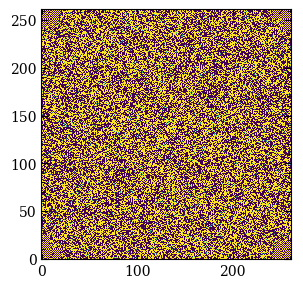

In [64]:
plt.imshow(np.real(new_img_iter), vmin=-250, vmax=1800)
# plt.colorbar()

### Plot FFTs of image, H, and SNR
Plot the SNR and the transformed arrays:

In [65]:
# xs = np.linspace(-N/2, N/2, N)
# ys = xs.copy()
# XS, YS = np.meshgrid(xs,ys)

# bg = 10
# bg_fft = bg*N
# sky = np.random.normal(0, bg, size=(N,N))
# sky_fft = fft.fft2(sky)

# Z = 1e5*np.exp(-(XS**2 + YS**2)/1000) 
# Z_fft = fft.fft2(Z)

# # Zconv = convolve(Z, psf, boundary=None) + np.random.normal(0, bg, size=(N,N))
# Zconv_fft = Z_fft*psf_fft + sky_fft


# snr_real = np.abs(Z_fft/bg_fft)
# Z_recon, H_snr = recon_new(Zconv_fft, psf_fft, snr_real)
# H_perfect = Z_fft/Zconv_fft


(1.0, 10000000000000.0)

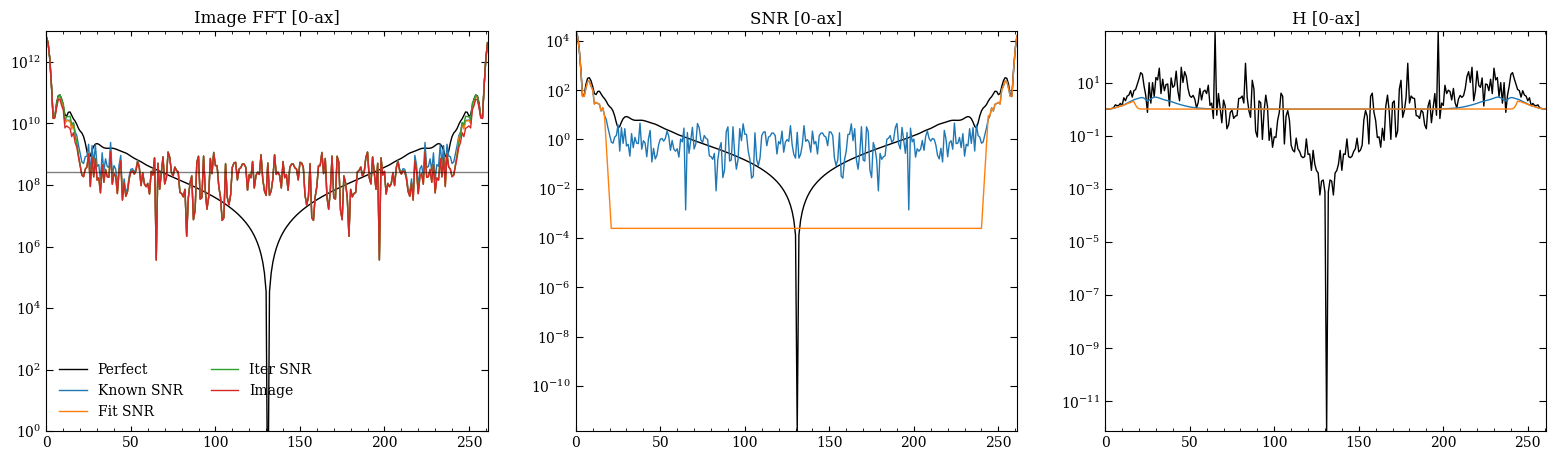

In [66]:
fig, axs = plt.subplots(1,3,figsize=(15,4))

# arrs = [[Z_fft, np.abs(Z_recon)-np.abs(Z_fft), Zconv_fft ],[snr_real, snr_real],[H_perfect, H_snr]]
# arrs = [[perfect_fft, new_img_snr, new_img_simple, new_img_iter, img_fft], [snr_real, snr_real, snr_simple, snr_iter], [H_perfect, H_snr, H_simple, H_iter]]
arrs = [[perfect_fft, new_img_snr,  new_img_fit, new_img_iter, img_fft], [snr_real, snr_simple, snr_iter], [H_perfect, H_snr, H_fit]]

colors = ['k', 'C0', 'C1', 'C2', 'C3']
labels = ['Perfect', 'Known SNR', 'Fit SNR','Iter SNR', 'Image', 'PSF']
# labels = ['Perfect', 'Known SNR', x'Wiener','Image', 'PSF']


nax = 0

for i, ax in enumerate(axs):
    for color, label, arr in zip(colors, labels, arrs[i]):
        ax.plot(np.abs(arr[:,nax])**2, label=label, color=color, lw=1)
    ax.set_yscale('log')
axs[0].legend(loc=3, ncols=2, frameon=False)
axs[0].set_title(f'Image FFT [{nax}-ax]')
axs[1].set_title(f'SNR [{nax}-ax]')
axs[2].set_title(f'H [{nax}-ax]')

axs[0].axhline(bg_fft**2, color='k', lw=1, alpha=0.5)
     
# plt.axhline(noise_fft**2, color='k', alpha=0.5, lw=0.5)
axs[0].set_ylim(1e-30, 1e14)
axs[0].set_ylim(1e0, 1e13)
# plt.yscale('log')

Actually plot an example iteration:

Plot these tests:

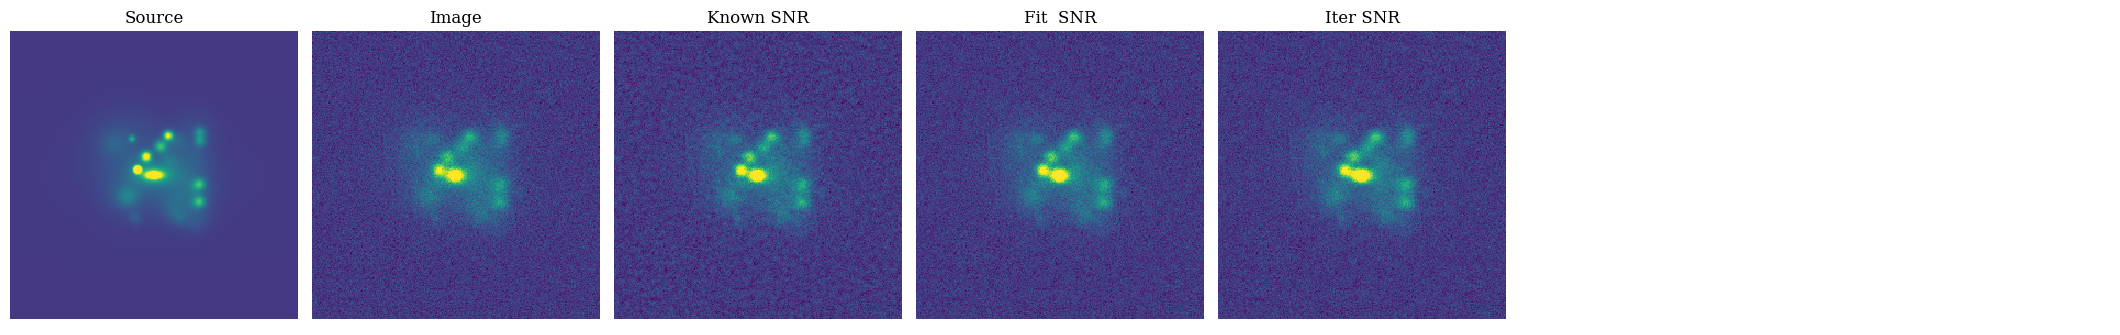

In [67]:
fig, axs = plt.subplots(1, 7, figsize=(7*3,3))
axs[0].imshow(perfect_gal, vmin=-200, vmax=1000); axs[0].set_title('Source')
axs[1].imshow(real_gal, vmin=-200, vmax=1000); axs[1].set_title('Image')

labels = ['Known SNR','Fit  SNR', 'Iter SNR']
for ax, img, l in zip(axs[2:], recons, labels):
    ax.imshow(np.real(fft.ifft2(img)), vmin=-200, vmax=1000)
    ax.set_title(l)

for ax in axs:    ax.axis('off')
plt.subplots_adjust(wspace=0.05)


In [100]:
true_a = get_a_nofft(perfect_gal, True)
img_a = get_a_nofft(real_gal, True)

img_recon = np.real(fft.ifft2(new_img_iter))

print(f'Source\t\t\tFlux:\t\t {np.sum(perfect_gal**2)/1e8:0.3f}\t\t A:\t {true_a}')
print(f'Image\t\t\tFlux:\t\t {(np.sum(real_gal**2) - (bg*N)**2)/1e8:0.3f}\t\t A:\t {img_a}')

for H, label in zip(Hs, labels):
    noise = 0 if 'Wiener' in label else bg_fft
    a, flux = get_a_flux(real_gal, H, noise)
    print(f'{label}\t\tFlux:\t\t {flux/1e8:0.3f}', end='\t\t')
    print(f' A:\t', a)
    
recon_a = get_a_nofft(img_recon, True)
print(f' A:\t', recon_a)

# print(np.sum(img_recon**2)/1e8)

Source			Flux:		 1.922		 A:	 0.11203968222214819
Image			Flux:		 1.240		 A:	 0.01724907815655466
Known SNR		Flux:		 2.028		 A:	 0.6198010868491781
Fit  SNR		Flux:		 1.575		 A:	 0.2626642273861975
Iter SNR		Flux:		 1.575		 A:	 0.2626642273861975
 A:	 0.012572305998223954


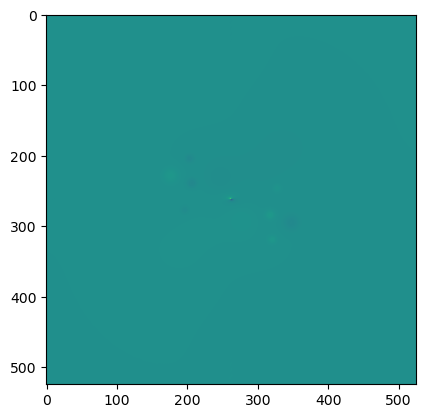

In [101]:
plt.imshow(perfect_gal - T.rotate(perfect_gal, 180, order=0), vmin=-3000, vmax=3000)

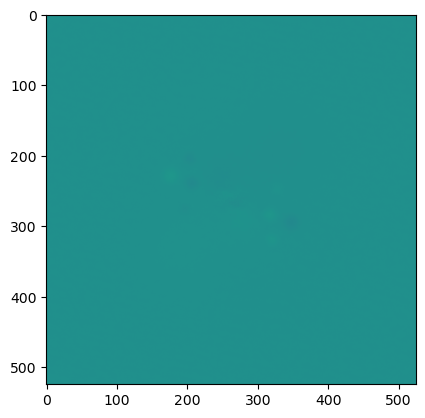

In [102]:
plt.imshow(img_recon - T.rotate(img_recon, 180, order=0), vmin=-3000, vmax=3000)

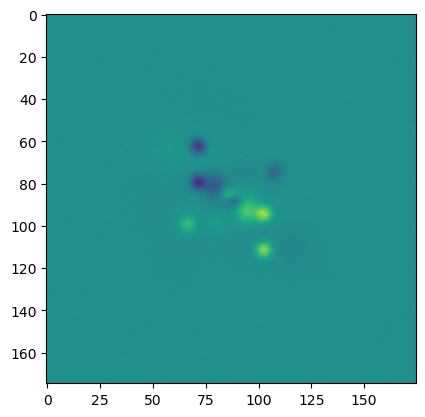

In [70]:
plt.imshow(real_gal - T.rotate(real_gal, 180, order=0), vmin=-3000, vmax=3000)

Asymmetry:

In [30]:
img_rotated = T.rotate(perfect_gal, 180, order=0)
# img_rotated_fft = fft.fft2(T.rotate(real_gal, 180, order=0))

true_a = np.sum( (perfect_gal-img_rotated)**2) / np.sum(perfect_gal**2)
rec_a = get_a_fft(real_gal, psf_fft, bg_fft, get_snr_real, recon_new, 1, perfect_fft)

print('True A:', true_a)
print('Recovered A:', rec_a)
# print('Recovered A (image):', rec_a_2)



True A: 0.5216178
Recovered A: 2.022098275479195


## Test vs background RMS and seeing

See how well these methods recover total flux (squared) as a function of background RMS and seeing.

In [105]:
def get_flux2(sky_mag, psf_fwhm, pxscale=0.1):

    # Generate an image
    source, obs, bg = make_perfect_galaxy(mag, r, 10.5, pxscale, n, q, n_clumps=20, sky_mag=sky_mag, psf_fwhm=psf_fwhm)
    
    # Create a PSF
    N = source.shape[0]
    psf_std = psf_fwhm * gaussian_fwhm_to_sigma
    psf = Gaussian2DKernel(x_stddev=psf_std/pxscale, x_size=N, y_size=N).array
    
    # Fourier transform
    img_fft = fft.fft2(obs)
    psf_fft = fft.fft2(fft.ifftshift(psf))
    
    # Calculate SNR
    bg_fft = bg * N
    snr = fit_snr(img_fft, bg_fft)

    # Calculate different transforms
    naive_img, H_naive = recon_naive(img_fft, psf_fft)
    wiener_img, H_wiener = recon_wiener(img_fft, psf_fft, snr)
    new_img, H_new = recon_iter(img_fft, psf_fft, bg_fft, recon_new, 3)

    # Calculate fluxes
    flux_arr = np.zeros(5)
    flux_arr[0] = np.sum(source**2)
    flux_arr[1] = np.sum(obs**2) - (bg*N)**2
    flux_arr[2] = np.sum(np.abs(naive_img)**2)/N**2 - (bg*N)**2
    flux_arr[3] = np.sum(np.abs(wiener_img)**2)/N**2 
    flux_arr[4] = np.sum(np.abs(new_img)**2)/N**2 - (bg*N)**2
    
    return flux_arr

Run this loop for a range of magnitudes and seeings

In [106]:
num_points = 3
bgs = np.linspace(22, 31, num_points)
seeings = np.linspace(0.2,3.0, num_points)
fluxes = np.zeros((num_points, num_points, 5))

for i, bg in tqdm(enumerate(bgs), total=num_points):
    for j, seeing in enumerate(seeings):

        fluxes[i,j,:] = get_flux2(bg, seeing)
      
# error_image = (fluxes[:,:,1] - fluxes[:,:,0])/fluxes[:,:,0]
# error_corr = (fluxes[:,:,2] - fluxes[:,:,0])/fluxes[:,:,0]



  0%|                                                     | 0/3 [00:02<?, ?it/s]


TypeError: 'int' object is not callable

Plot the flux arrays:

In [48]:
snr_ids = [0, 4, 7, 9]
# snr_ids = [0, 1,2,2]
labels = ['Image', 'Naive', 'Wiener', 'New']

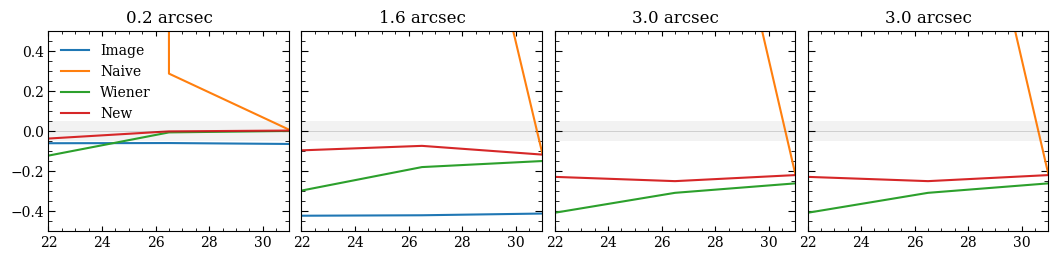

In [49]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2), sharey=True)
for i, ax, l in zip(snr_ids, axs, labels):
    for j in range(4):
        ax.plot(bgs, (fluxes[:,i,j+1]-fluxes[:,i,0])/fluxes[:,i,0], label=labels[j])
    ax.set_title(f'{seeings[i]:0.1f} arcsec')
    ax.set_ylim(-0.5,0.5)
    ax.axhspan(-0.05, 0.05, color='k', alpha=0.05)
    ax.axhline(0, color='k', alpha=0.2, lw=0.5)
axs[0].legend()
plt.subplots_adjust(wspace=0.05)

## Same, but for asymmetry

In [19]:
def calc_a(img, rot, N, noise=0, fft=False, H=None):

    if fft:
        top = img-rot
        top = np.sum(np.real(top*np.conj(top)*H**2))/N**2 - 2*(N*noise)**2
        bot = np.sum(img*H*np.conj(img*H))/N**2 - (N*noise)**2
        a = np.abs(top / bot)
    else:
        top = img-rot
        top = np.sum(top**2) - 2*(N*noise)**2
        bot = np.sum(img**2) - (N*noise)**2
        a = top/bot
    return a
        

In [68]:
def get_a(sky_mag, psf_fwhm, pxscale=0.1):

    # Generate an image
    source, obs, bg = make_perfect_galaxy(mag, r, 10.5, pxscale, 1.5, q, n_clumps=20, sky_mag=sky_mag, psf_fwhm=psf_fwhm)
    source_rot = T.rotate(source, 180, order=0)
    obs_rot = T.rotate(obs, 180, order=0)

    # Create a PSF
    N = source.shape[0]
    psf_std = psf_fwhm * gaussian_fwhm_to_sigma
    # psf_std = psf_std + norm.rvs(loc=0, scale=0.1*gaussian_fwhm_to_sigma, size=psf_std.shape)
    psf = Gaussian2DKernel(x_stddev=psf_std/pxscale, x_size=N, y_size=N).array
    
    # Fourier transform
    img_fft = fft.fft2(obs)
    rot_fft = fft.fft2(obs_rot)
    psf_fft = fft.fft2(fft.ifftshift(psf))
    
    # Calculate SNR
    bg_fft = bg * N
    snr = fit_snr(img_fft, bg_fft)
    snr_rot = fit_snr(rot_fft, bg_fft)

    # Calculate different transforms
    naive_img, H_naive = recon_naive(img_fft, psf_fft)
    wiener_img, H_wiener = recon_wiener(img_fft, psf_fft, snr)
    new_img, H_new = recon_new(img_fft, psf_fft, snr)
    
    # Also for rotations
    naive_rot, _ = recon_naive(rot_fft, psf_fft)
    wiener_rot, _ = recon_wiener(rot_fft, psf_fft, snr_rot)
    new_rot, _ = recon_new(rot_fft, psf_fft, snr_rot)
    
    # Calculate CAS error
    a_cas = (np.sum(np.abs(obs-obs_rot)) - 0.8*bg*N)/np.sum(np.abs(obs))
    a_cas_real = (np.sum(np.abs(source-source_rot)))/np.sum(np.abs(source))
    cas_err = (a_cas - a_cas_real)/a_cas_real

    # Calculate fluxes
    a_arr = np.zeros(5)
    a_arr[0] = calc_a(source, source_rot, N, 0, False)
    a_arr[1] = calc_a(obs, obs_rot, N, bg, False)
    a_arr[2] = calc_a(img_fft, rot_fft, N, bg, True, H_naive)
    a_arr[3] = calc_a(img_fft, rot_fft, N, 0, True, H_wiener)
    a_arr[4] = calc_a(img_fft, rot_fft, N, bg, True, H_new)
    
    return a_arr, cas_err

In [69]:
num_points = 10
bgs = np.linspace(22, 31, num_points)
seeings = np.linspace(0.2,2.2, num_points)
a_arr = np.zeros((num_points, num_points, 5))
cas_errs = np.zeros((num_points, num_points))

for i, bg in tqdm(enumerate(bgs), total=num_points):
    for j, seeing in enumerate(seeings):

        a_vals, cas_err = get_a(bg, seeing)
        a_arr[i,j,:] = a_vals
        cas_errs[i,j] = cas_err
      
# error_image = (fluxes[:,:,1] - fluxes[:,:,0])/fluxes[:,:,0]
# error_corr = (fluxes[:,:,2] - fluxes[:,:,0])/fluxes[:,:,0]



100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.01s/it]


In [80]:
snr_ids = [0, 6, 15, 29]
snr_ids = [0, 4, 6, 9]
snr_ids = [0,6,9]
labels = [r'Image', r'Image/$\lambda$', r'Wiener', r'Noisy wiener', 'CAS |A|']
colors = ['C0', 'C3', 'C2', 'C1', 'k']

skip_j = [0,1,2]

In [81]:
plt.rcParams['font.size']=13

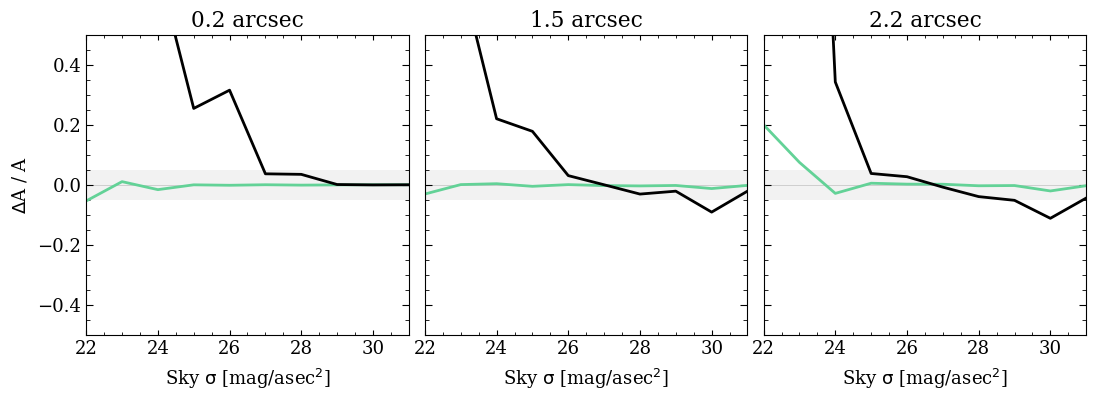

In [82]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for i, ax, l in zip(snr_ids, axs, labels):
    ax.axhspan(-0.05, 0.05, color='k', alpha=0.05)
    ax.axhline(0, color='k', alpha=0.2, lw=0.5)
    
    for j in range(4):
        if j in skip_j: continue
        ax.plot(bgs, (a_arr[:,i,j+1]-a_arr[:,i,0])/a_arr[:,i,0], label=labels[j], color='#63D297', lw=2)
    ax.plot(bgs, cas_errs[:,i], label='|A|', color='k', lw=2)
    ax.set_title(f'{seeings[i]:0.1f} arcsec')
    ax.set_xlabel(r'Sky $\sigma$ [mag/asec$^2$]')
    
# for i, (label, color) in enumerate(zip(labels, colors)):
#     axs[0].annotate(label, color=color, xycoords='axes fraction', size=9, ha='left', va='center',
#                     xy=(0.05+int(i/3)*0.27, 0.3 - (i%3)*0.1))#0))
axs[0].set_ylim(-0.5,0.5)
# axs[0].legend(ncols=2)
axs[0].set_ylabel(r'$\Delta$A / A')
plt.subplots_adjust(wspace=0.05)


In [ ]:
# def get_a_real(obs, psf_fwhm, bg, pxscale=0.1):

#     obs_rot = T.rotate(obs, 180, order=0)

#     # Create a PSF
#     N = obs.shape[0]
#     psf_std = psf_fwhm * gaussian_fwhm_to_sigma
#     # psf_std = psf_std + norm.rvs(loc=0, scale=0.1*gaussian_fwhm_to_sigma, size=psf_std.shape)
#     psf = Gaussian2DKernel(x_stddev=psf_std/pxscale, x_size=N, y_size=N).array
    
#     # Fourier transform
#     img_fft = fft.fft2(obs)
#     rot_fft = fft.fft2(obs_rot)
#     psf_fft = fft.fft2(fft.ifftshift(psf))
    
#     # Calculate SNR
#     bg_fft = bg * N
#     snr = fit_snr(img_fft, bg_fft)
#     snr_rot = fit_snr(rot_fft, bg_fft)

#     # Calculate different transforms
#     wiener_img, H_wiener = recon_wiener(img_fft, psf_fft, snr)
#     new_img, H_new = recon_new(img_fft, psf_fft, snr)
#     return wiener_img

#     # Also for rotations
#     wiener_rot, _ = recon_wiener(rot_fft, psf_fft, snr_rot)
#     new_rot, _ = recon_new(rot_fft, psf_fft, snr_rot)
    
#     # Calculate CAS error
#     # a_cas = (np.sum(np.abs(obs-obs_rot)) - 0.8*bg*N)/np.sum(np.abs(obs))
#     # a_cas_real = (np.sum(np.abs(source-source_rot)))/np.sum(np.abs(source))
#     # cas_err = (a_cas - a_cas_real)/a_cas_real

#     # Calculate fluxes
#     # a_arr = np.zeros(5)
#     # a_arr[0] = calc_a(source, source_rot, N, 0, False)
#     # a_arr[1] = calc_a(obs, obs_rot, N, bg, False)
#     # a_arr[2] = calc_a(img_fft, rot_fft, N, bg, True, H_naive)
#     # a_arr[3] = calc_a(img_fft, rot_fft, N, 0, True, H_wiener)
#     a = calc_a(img_fft, rot_fft, N, bg, True, H_new)
    
#     return a